In [12]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr
import DarkVerse as dv


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")  #"Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits"
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table
t=join(t,t3,keys='id') 
#t.rename_column('ra_1','ra')
#t.rename_column('dec_1','dec')
t.rename_column('mode_z','z')
t.rename_column('mode_mass','SM')



#!!! remove stars 
t = t[t['kNN_class'] != 2]   


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}







In [13]:
delta_mag = t['bdf_mag_dered_calib_i'] - t['psf_mag_dered_calib_i']


/tmp/ipykernel_662716/811462672.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


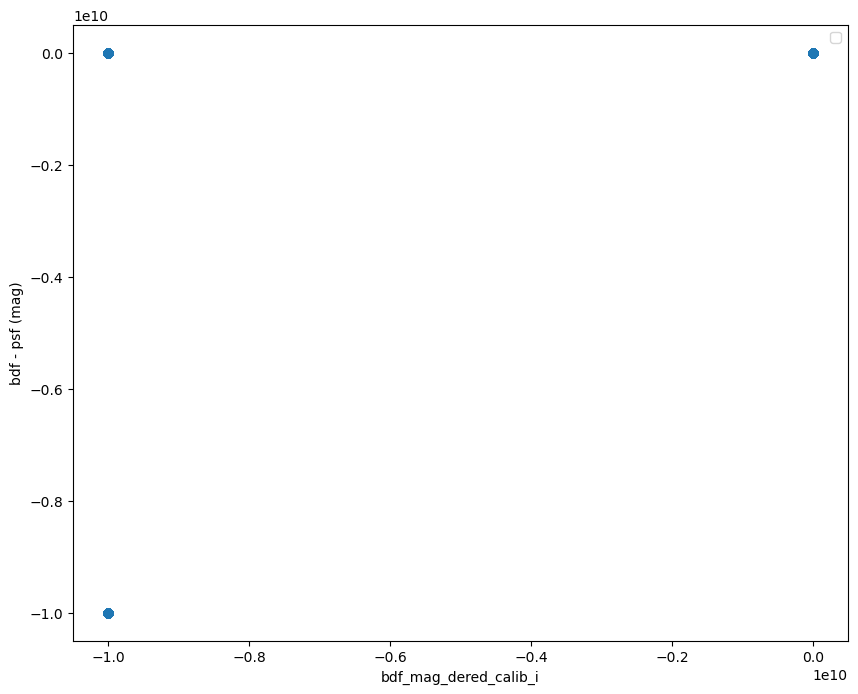

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(t['bdf_mag_dered_calib_i'], delta_mag)
plt.xlabel('bdf_mag_dered_calib_i')
plt.ylabel('bdf - psf (mag)')
plt.legend()
plt.show()

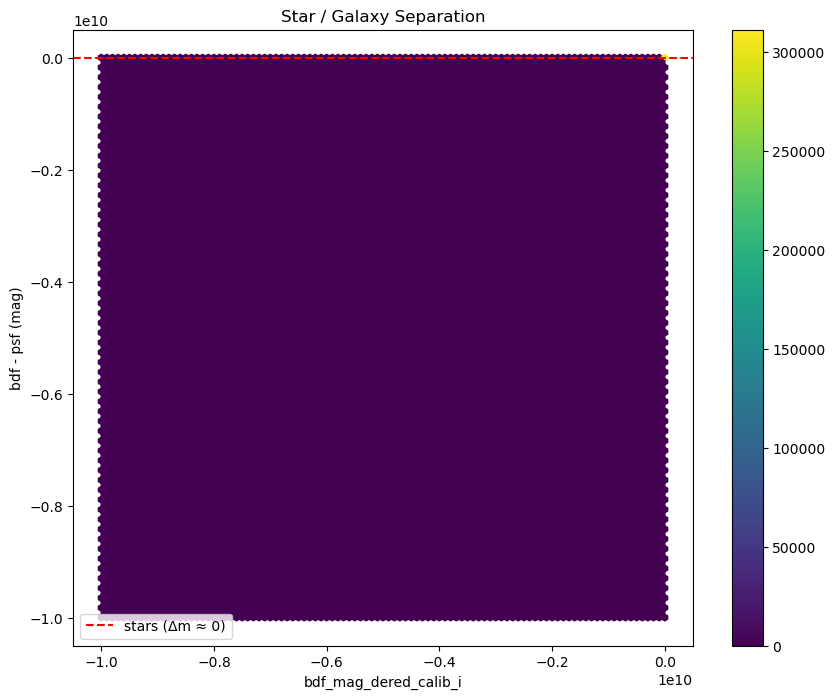

In [15]:
plt.figure(figsize=(10,8))
plt.hexbin(t['bdf_mag_dered_calib_i'], delta_mag, cmap='viridis')
plt.colorbar()
plt.xlabel('bdf_mag_dered_calib_i')
plt.ylabel('bdf - psf (mag)')
plt.axhline(0, color='r', linestyle='--', label='stars (Δm ≈ 0)')
plt.legend()
plt.title('Star / Galaxy Separation')
plt.show()

### Apply a compactness cut (default Δm < -0.05 keeps galaxies)?

In [16]:

def load_and_clean_catalog(path, compactness_cut=-0.05):
    """
    Read a FITS catalog and apply star/galaxy separation.

    """
    cat = Table.read(path)

    # Remove stars 
    if 'kNN_class' in cat.colnames:
        cat = cat[cat['kNN_class'] != 2]


    # Apply compactness cut: Δm = bdf - psf
    bdf_col = 'bdf_mag_dered_calib_i'
    psf_col = 'psf_mag_dered_calib_i'
    if bdf_col in cat.colnames and psf_col in cat.colnames:
        delta_mag = cat[bdf_col] - cat[psf_col]
        cat = cat[delta_mag < compactness_cut]  # keep galaxies

    return cat

fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")
t = load_and_clean_catalog(fits_file_path)

masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")
t3 = load_and_clean_catalog(masked_file_path)

# Join in one table
t = join(t, t3, keys='id')
t.rename_column('mode_z', 'z')
t.rename_column('mode_mass', 'SM')

# Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits")
randoms = load_and_clean_catalog(fits_random)


In [17]:
# Check flagged objects
flagged_mask = (t['flags'] > 0) | (t['flags_nir'] > 0)  # flags>0 or flags_nir>0 

n_flagged = np.sum(flagged_mask)
n_total = len(t)
# what fraction of objects have flags>0 or flags_nir>0 after cross-matching with the masked cat
fraction_flagged = n_flagged / n_total

print(f"Number of objects flagged: {n_flagged}/{n_total}")
print(f"Fraction of flagged objects: {fraction_flagged:.3%}")


Number of objects flagged: 2866/248609
Fraction of flagged objects: 1.153%


### If it's a small fraction (a few percent), then we can exclude them. We might need to anyway, they might not have valid values for the fluxes etc., so then it's just good to know how many there are.

In [18]:
def load_and_clean_catalog(path, compactness_cut=-0.05):
    """
    Read a FITS catalog and apply star/galaxy separation and flag cleaning.

    """
    cat = Table.read(path)

    # --- Remove stars ---
    if 'kNN_class' in cat.colnames:
        cat = cat[cat['kNN_class'] != 2]

    # --- Compactness cut: Δm = bdf - psf ---
    bdf_col = 'bdf_mag_dered_calib_i'
    psf_col = 'psf_mag_dered_calib_i'
    if bdf_col in cat.colnames and psf_col in cat.colnames:
        delta_mag = cat[bdf_col] - cat[psf_col]
        cat = cat[delta_mag < compactness_cut]

    return cat

def exclude_flagged_objects(cat):
    """
    Exclude objects with flags > 0 or flags_nir > 0.

    """
    flagged_mask = np.zeros(len(cat), dtype=bool)
    if 'flags' in cat.colnames:
        flagged_mask |= cat['flags'] > 0
    if 'flags_nir' in cat.colnames:
        flagged_mask |= cat['flags_nir'] > 0

    return cat[~flagged_mask]

fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")
t = load_and_clean_catalog(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")
t3 = load_and_clean_catalog(masked_file_path)
t = join(t, t3, keys='id')
t.rename_column('mode_z', 'z')
t.rename_column('mode_mass', 'SM')
t = exclude_flagged_objects(t)

fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits")
randoms = load_and_clean_catalog(fits_random)
randoms = exclude_flagged_objects(randoms)

print(f"Cleaned science catalog: {len(t)} objects")
print(f"Cleaned random catalog: {len(randoms)} objects")


Cleaned science catalog: 245743 objects
Cleaned random catalog: 13402307 objects


In [19]:
# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

z_min, z_max = 0.3, 0.6
SM_min, SM_max = 10, 12.5
    
#mask_theta = (theta >= 0.004) & (theta <= 0.4)

In [20]:
sub1 = dv.Selection(t,randoms,z_min,z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


<>:37: SyntaxWarning: invalid escape sequence '\i'
<>:37: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_662716/1639475363.py:37: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


HOD fit results: M_min = 10^12.15, M_1 = 10^13.42, alpha = 1.09


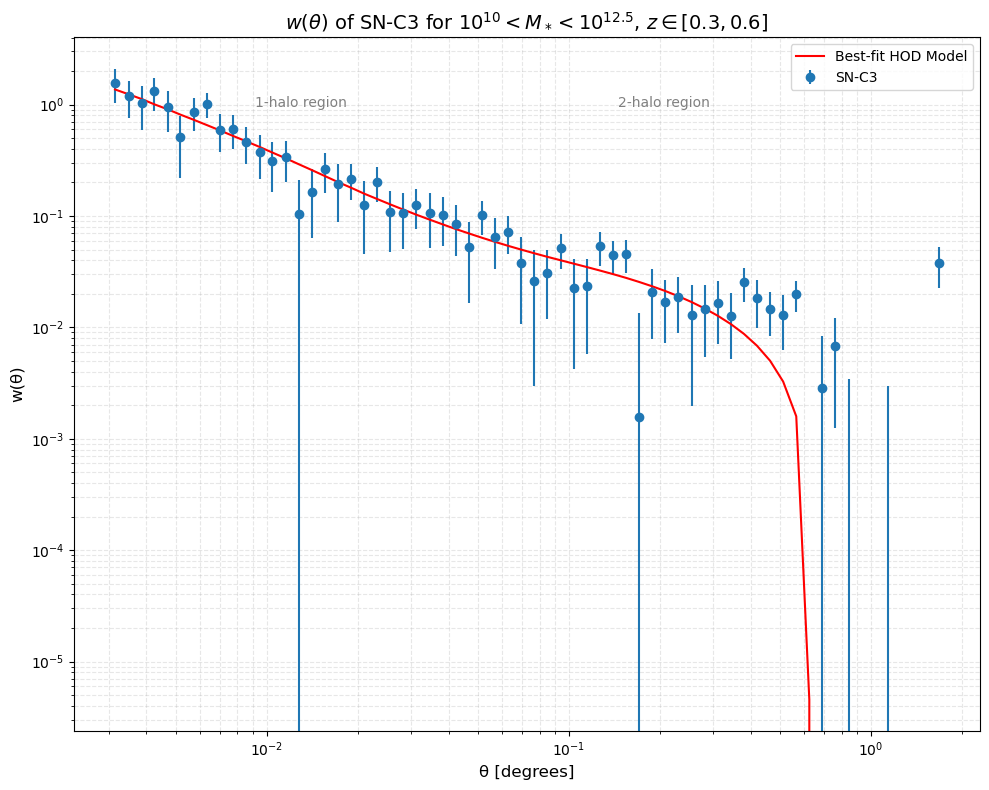

In [21]:

# Fit HOD with custom bounds
#hod_params, pcov = sub1.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds = ([11.0*1e-7, 12.5, 0.99], [14.5*1e-7, 15.5, 1.01]) # fix alpha to 1
hod_params, pcov = sub1.fit_hod(p0=[12.3*1e-7, 13.5, 1.0]) 


results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']

# Model prediction with best-fit parameters
w_model = sub1.hod_model(logM_min *1e7, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')
#plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')

plt.savefig(f"wtheta_SN_C3_HOD_SM_{SM_min}_{SM_max}_{z_min}_{z_max}.png")

plt.tight_layout()
plt.show()